In [2]:
import numpy as np
import re
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
!pip install gensim
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def get_indices(data,dev_data=None, test_data=None):

    l1 = len(data)
    l2, l3 = 0, 0

    if dev_data:
        data.extend(dev_data)
        l2 = len(dev_data)
    if test_data:
        data.extend(test_data)
        l3 = len(test_data)

    goog_w2v_path = '/content/drive/MyDrive/Colab Notebooks/DL/a3/GoogleNews-vectors-negative300.bin'
    model = KeyedVectors.load_word2vec_format(goog_w2v_path, binary=True)
    vocab_dict = {}
    weights = [model['pad'], model['unk']]
    for i, sentence in enumerate(data):
        for j, token in enumerate(sentence):

            if token in vocab_dict:
                sentence[j] = vocab_dict[token]
            else:
                if token in model.vocab:
                    weights.append(model[token])
                    vocab_dict[token] = len(weights) - 1
                    sentence[j] = len(weights) - 1
                elif token == '<pad>':
                    sentence[j] = 0
                else:
                    sentence[j] = 1
        data[i] = sentence

    return data[0:l1], data[l1:l1+l2], data[l1+l2:l1+l2+l3], weights


def tokenize(data, max_len=None):
    data = [sentence.split(' ')[0:max_len] for sentence in data]
    max_sentence = len(max(data, key=len))
    return data, max_sentence

In [4]:
def clean_str(string):

    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", "", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"\s{2,}", " ", string)
  
    return string.strip().lower()

def pad(data, max_sen_len):
    for i in range(len(data)):
        sentence = data[i]
        if len(sentence) < max_sen_len:
            diff = max_sen_len - len(sentence)
            sentence.extend(['<pad>' for _ in range(diff)])
        data[i] = sentence
    return data

In [5]:
 # Label: Description = 0, Entity = 1, Abbreviation = 2, Human = 3, Number = 4, Location = 5"
# opening the dataset and reading it line by line
line_list = list(open("/content/drive/MyDrive/Colab Notebooks/DL/a3/Trec_Train_dataset.txt", "r",encoding='ISO-8859-1').readlines())
label_ids = {"DESC:": 0, "ENTY:": 1, "ABBR:": 2, "HUM:": 3, "NUM:": 4, "LOC:": 5}
data = []
labels = [] 

In [28]:
len(labels)

5452

In [6]:
for line in line_list:
  for label in label_ids:
    if label in line:
      # Append label number to labels
      labels.append(label_ids[label])
      remove = ""
      for i in line:
        if i == " ":
          break
        remove += i
      # Remove the label from the front of the string
      data.append(line.replace(remove + " ", "")[:-1])

In [11]:
data
len(data)
labels
data1 = [clean_str(s.strip()) for s in data]
len(data1)


5452

In [16]:
##############  TRAIN DATA and TEST DATA
train_data = data1[:4362]
test_data = data1[4362:]

train_labels = labels[:4362]
test_labels = labels[4362:]


In [17]:
#################  TOKENIZE ####################
train_data, train_max_sen_len = tokenize(train_data)
test_data, test_max_sen_len = tokenize(test_data)

In [31]:
max_sen_len = max(train_max_sen_len, test_max_sen_len)

In [34]:
max_sen_len

33

In [19]:
train_data = pad(train_data, max_sen_len)
test_data = pad(test_data, max_sen_len)

In [20]:
train_data, test_data, _, weights = get_indices(train_data, test_data)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from gensim.models import KeyedVectors

class Net(nn.Module):
    def __init__(self, EMBEDDINGS, BATCH_SIZE, M_TYPE='NOT_STATIC', N_KERN=100, E_DIMS=300, E_NUMB=662109, DROP=0, C_SIZE=2, TRAIN=True, M_SENT_LEN=40):
        super(Net, self).__init__()

        # Need to update the way arguments are passed into this, C_SIZE, M_SENT_LEN are incorrect values
        self.EMBEDDINGS = EMBEDDINGS
        self.BATCH_SIZE = BATCH_SIZE
        self.M_TYPE = M_TYPE
        self.E_DIMS = E_DIMS
        self.E_NUMB = E_NUMB
        self.N_KERN = N_KERN
        self.DROP   = DROP
        self.C_SIZE = C_SIZE
        self.TRAIN  = TRAIN
        self.M_S_L  = M_SENT_LEN
        self.NUM_INPUT_C = 1

        # path = 'data/embedding_models/GoogleNews-vectors-negative300.bin'
        # embedding_model = KeyedVectors.load_word2vec_format(path, binary=True)
        # weights = torch.FloatTensor(embedding_model.vectors)

        vocab_size = len(EMBEDDINGS)
        print(f'VOCAB SIZE = {vocab_size}')
        weights = torch.FloatTensor(EMBEDDINGS)

        if M_TYPE == 'RANDOM':
            self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=E_DIMS, padding_idx=0)
        elif M_TYPE == 'NOT_STATIC':
            self.embedding = nn.Embedding.from_pretrained(weights, freeze=False, padding_idx=0)
        elif M_TYPE == 'STATIC':
            self.embedding = nn.Embedding.from_pretrained(weights, freeze=True, padding_idx=0)
        elif M_TYPE == 'MULTI':
            self.embedding = nn.Embedding.from_pretrained(weights, freeze=False, padding_idx=0)
            self.embedding_static = nn.Embedding.from_pretrained(weights, freeze=True, padding_idx=0)
            self.NUM_INPUT_C = 2
        else:
            print('Invalid M_TYPE')
            return

        '''
        # For testing
        self.embedding = nn.Embedding(E_DIMS, E_NUMB)
        '''
        # nn.Conv2d(n_inp, n_outp, kern_size, stride)
        self.conv1 = nn.Conv2d(self.NUM_INPUT_C, N_KERN, (3, E_DIMS), 1)
        self.conv2 = nn.Conv2d(self.NUM_INPUT_C, N_KERN, (4, E_DIMS), 1)
        self.conv3 = nn.Conv2d(self.NUM_INPUT_C, N_KERN, (5, E_DIMS), 1)
        self.dropout = nn.Dropout(DROP)
        self.fc1   = nn.Linear(3*N_KERN, C_SIZE)       
        
    def forward(self, x):

        
        if self.M_TYPE == 'MULTI':
            x_s = self.embedding_static(x)
            x_s = x_s.view((-1, 1, self.M_S_L, self.E_DIMS))
            x = self.embedding(x)
            x = x.view((-1, 1, self.M_S_L, self.E_DIMS))
            x = torch.cat((x_s, x), dim=1) # Concatenate along "Cin" dimension
        else:
            x = self.embedding(x)
            x = x.view((-1, 1, self.M_S_L, self.E_DIMS))

        '''
        if self.TYPE == 'STATIC':
            x = torch.autograd.Variable(x)
        '''

        x_f1 = F.max_pool1d(F.relu(self.conv1(x)).squeeze(3), self.M_S_L - 3)
        x_f2 = F.max_pool1d(F.relu(self.conv2(x)).squeeze(3), self.M_S_L - 3)
        x_f3 = F.max_pool1d(F.relu(self.conv3(x)).squeeze(3), self.M_S_L - 4)
        x = torch.cat((x_f1, x_f2, x_f3), 1)
        
        x = self.dropout(x)
        x = self.fc1(x.squeeze(2))
        
        return x


In [39]:
import torch
import torch.nn as nn
import numpy as np
import time
import datetime
from sklearn.model_selection import train_test_split
import argparse
import os
import matplotlib.pyplot as plt




Running on the GPU
VOCAB SIZE = 7259
[1,  75] train loss: 0.5851 train acc: 0.8400
EPOCH TIME: 0.45s
[2,  75] train loss: 0.3597 train acc: 0.8800
EPOCH TIME: 0.36s
[3,  75] train loss: 0.2095 train acc: 0.9600
EPOCH TIME: 0.38s
[4,  75] train loss: 0.0991 train acc: 0.9800
EPOCH TIME: 0.35s
[5,  75] train loss: 0.0703 train acc: 0.9600
EPOCH TIME: 0.34s
[6,  75] train loss: 0.0432 train acc: 1.0000
EPOCH TIME: 0.35s
[7,  75] train loss: 0.0356 train acc: 0.9800
EPOCH TIME: 0.35s
[8,  75] train loss: 0.0232 train acc: 1.0000
EPOCH TIME: 0.35s
[9,  75] train loss: 0.0335 train acc: 0.9800
EPOCH TIME: 0.35s
[10,  75] train loss: 0.0074 train acc: 1.0000
EPOCH TIME: 0.37s
[11,  75] train loss: 0.0171 train acc: 1.0000
EPOCH TIME: 0.38s
[12,  75] train loss: 0.0040 train acc: 1.0000
EPOCH TIME: 0.36s
[13,  75] train loss: 0.0309 train acc: 0.9800
EPOCH TIME: 0.38s
[14,  75] train loss: 0.0247 train acc: 0.9800
EPOCH TIME: 0.38s
[15,  75] train loss: 0.0035 train acc: 1.0000
EPOCH TIME: 0.

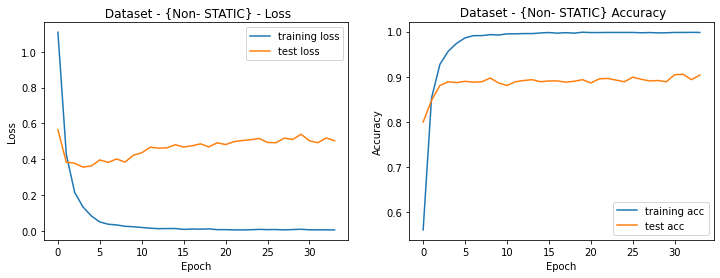

In [50]:
def train_model(OPTIMIZER = 'SGD' ):

  x_train, y_train, x_test, y_test, max_sen_len, n_classes, weights1 = train_data,train_labels,test_data,test_labels,33,6,weights
    

  if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
  else:
    device = torch.device("cpu")
    print("Running on the CPU")

  x_train_tensor = torch.LongTensor(x_train)
  y_train_tensor = torch.LongTensor(y_train)
  x_test_tensor = torch.LongTensor(x_test).to(device)
  y_test_tensor = torch.LongTensor(y_test).to(device)

  train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
    # trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

  cnn = Net(EMBEDDINGS=weights1, BATCH_SIZE=50, M_TYPE='NOT_STATIC', E_DIMS=300, M_SENT_LEN=max_sen_len, DROP=0.5, C_SIZE=n_classes).to(device)

  criterion = nn.CrossEntropyLoss()
  if OPTIMIZER == 'SGD':
      optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9)
  elif OPTIMIZER == 'ADADELTA':
      optimizer = torch.optim.Adadelta(cnn.parameters(), lr=0.1, weight_decay=0.01)
  elif OPTIMIZER == 'ADAM':
      optimizer = torch.optim.Adam(cnn.parameters(), lr=0.1, weight_decay=0.01)
  else:
      print('No optimizer specified')
      return
  train_loss_history = []
  train_acc_history = []
  valid_loss_history = []
  valid_acc_history = []
  N_EPOCHS = 50
  for epoch in range(N_EPOCHS):
    if epoch > 3:
      if abs(train_loss_history[-1] - train_loss_history[-2]) < 0.0001 and abs(train_loss_history[-2] - train_loss_history[-3]) < 0.0001:
        break

    epoch_start = time.time()
    # print(f'===== EPOCH {epoch + 1}/{N_EPOCHS} =====', file=f)
    # print(f'===== EPOCH {epoch + 1}/{N_EPOCHS} =====')
    one_epoch_acc_history = []
    one_epoch_loss_history = []

    cnn.train()
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True)

    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()
        
      # forward + backward + optimize
      outputs = cnn(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # calculate mini-batch training accuracy
      predictions = torch.argmax(outputs, dim=1).detach()
      acc = (predictions == labels).sum().item() / len(labels)
      one_epoch_acc_history.append(acc)
      PRINT_FREQ = 75
      # print mini-batch statistics
      minibatch_loss = loss.item()
      one_epoch_loss_history.append(minibatch_loss)
      if i % PRINT_FREQ == PRINT_FREQ - 1: 
        # print every PRINT_FREQ mini-batches
        print('[%d, %3d] train loss: %.4f train acc: %.4f' % (epoch + 1, i + 1, minibatch_loss, acc))

    train_loss = np.mean(one_epoch_loss_history)
    train_acc = np.mean(one_epoch_acc_history)
  

        # run validation data
    with torch.no_grad():
      cnn.eval()
      outputs = cnn(x_test_tensor)
      valid_loss = criterion(outputs, y_test_tensor).item()
    valid_predictions = torch.argmax(outputs, dim=1).detach()
    valid_n_correct = (valid_predictions == y_test_tensor).sum().item()
    valid_acc = valid_n_correct / len(y_test_tensor)


        # save average loss, acc for this epoch
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    valid_loss_history.append(valid_loss)
    valid_acc_history.append(valid_acc)
    print(f'EPOCH TIME: {(time.time() - epoch_start):.2f}s')

  # print('Finished Training', file=f)
  print('Finished Training')


  # f.close()

  fig, axs = plt.subplots(2, 1, figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_loss_history, label='training loss')
  plt.plot(valid_loss_history, label='test loss')
  plt.title(' Dataset - {Non- STATIC} - Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
    # plt.savefig(f'{name}_LOSS')

  plt.subplot(1, 2, 2)
  plt.plot(train_acc_history, label='training acc')
  plt.plot(valid_acc_history, label='test acc')
  plt.title(' Dataset - {Non- STATIC} Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  fig_name = 'one'
  plt.savefig(fig_name)

  return cnn, max(valid_acc_history)


if __name__ == '__main__':

    print()


    cnn = train_model()


In [20]:
import joblib

filename = 'data111.sav'
joblib.dump(train_data1, filename)

filename1 = 'weights111.sav'
joblib.dump(weights, filename1)

['weights111.sav']